# Predicting Usage of a Video Game Research Server

Frank Wood and his research group from UBC have collected data on the behaviours of various players in a Minecraft server. In particular, they have noted whether or not a player is subscribed to a game-related newsletter. This study aims to determine if played hours and the age of players can accurately predict whether players are subscribed to a game-related newsletter in Wood’s research Minecraft server through a K-Nearest Neighbor classification model.

## Library Loading
The analysis will use the following three libraries:
- tidyverse
- repr
- tidymodels

In [118]:
library(tidyverse)
library(repr)
library(tidymodels)

## Randomness
To make the analysis reproducible, the `set.seed` function is used.

In [119]:
set.seed(5678)

## Data Loading

In order to build the model, the dataset is first loaded using R's built-in `read_csv` function.

In [120]:
# load data code
players_data <- read_csv("players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Data Cleaning and Wrangling

First, the columns are renamed using the `rename` function from the `dplyr` package to ensure consistency across the dataset.

In [121]:
players_data <- rename(players_data,
    is_subscribed = subscribe,
    hashed_email = hashedEmail,
    age = Age)
head(players_data)

experience,is_subscribed,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Then the variables of interest are selected from the dataset:
- is_subscribed (target variable)
- played_hours (predictor)
- age (predictor)

In [122]:
players_data <- players_data |>
    select(is_subscribed, played_hours, age)
head(players_data)

is_subscribed,played_hours,age
<lgl>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Since the `subscribe` column will be used as a categorical variable, it is convereted to a factor type from a logical type using the `as_factor` function.

In [123]:
players_data <- players_data |>
    mutate(is_subscribed = as_factor(is_subscribed))
glimpse(players_data)

Rows: 196
Columns: 3
$ is_subscribed <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ played_hours  <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, …
$ age           <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 1…


To ensure that the dataset does not contain any missing values, the `drop_na` function is used to remove any observations with empty cells.

In [124]:
players_data <- players_data |> drop_na()

### Data Splits
Finally, the data is split with a training to testing ratio of 75:25 using the `initial_split` function and the `is_subscribed` target variable as a stratum. This will allow the classifier to be evaluated after training.

In [125]:
players_split <- initial_split(players_data, prop = 0.75, strata = is_subscribed)
players_train <- training(players_split)
players_test <- testing(players_split)

glimpse(players_train)
glimpse(players_test)

Rows: 145
Columns: 3
$ is_subscribed <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ played_hours  <dbl> 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 1.4, 0.0, 0.0, 0.0, 0…
$ age           <dbl> 17, 21, 22, 17, 23, 18, 33, 25, 24, 23, 42, 22, 37, 28, …
Rows: 49
Columns: 3
$ is_subscribed <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ played_hours  <dbl> 3.8, 0.0, 48.4, 0.5, 0.7, 0.6, 0.0, 0.1, 0.0, 0.4, 2.2, …
$ age           <dbl> 17, 17, 17, 17, 21, 28, 17, 21, 17, 20, 24, 17, 27, 18, …


### Data Preprocessing

To prepare the data for analysis, the values should also be standardized by scaling with `step_scale` and centering with `step_center`.

In [126]:
std_recipe <- recipe(is_subscribed ~ ., data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

std_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [127]:
prep_std_recipe <- prep(std_recipe)
prep_data <- bake(prep_std_recipe, players_train)
head(prep_data)

played_hours,age,is_subscribed
<dbl>,<dbl>,<fct>
-0.2141180,-0.5626268,FALSE
-0.2141180,0.1172139,FALSE
-0.2141180,0.2871741,FALSE
-0.2104373,-0.5626268,FALSE
-0.2141180,0.4571343,FALSE
-0.2104373,-0.3926666,FALSE


To get a hold of what the dataset looks like, `group_by` and `summarize` is used to figure out the number and percentage of observations for both subscribed and unsubscribed players.

In [128]:
num_obs <- nrow(prep_data)
prep_data |>
    group_by(is_subscribed) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )

is_subscribed,count,percentage
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


The results show that there is class imabalnce in the dataset as subscribed players are found much more often than unsubscribed players. To get around this issue, the rarer class, unsubscribed players, will be oversampled by replicating the observations.

In [129]:
library(themis)

ups_recipe <- recipe(is_subscribed ~ ., data = players_train) |>
    step_upsample(is_subscribed, over_ratio = 1, skip = FALSE)

ups_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Up-sampling based on: is_subscribed



In [130]:
prep_ups_recipe <- prep(ups_recipe)

prep_data <- bake(prep_ups_recipe, prep_data)

num_obs <- nrow(prep_data)
prep_data |>
    group_by(is_subscribed) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )

is_subscribed,count,percentage
<fct>,<int>,<dbl>
FALSE,106,50
TRUE,106,50


## Exploratory Data Visualization

A colorblind-friendly scatter plot is created with `ggplot` to help visualize the two predictor variables: played_hours and age.

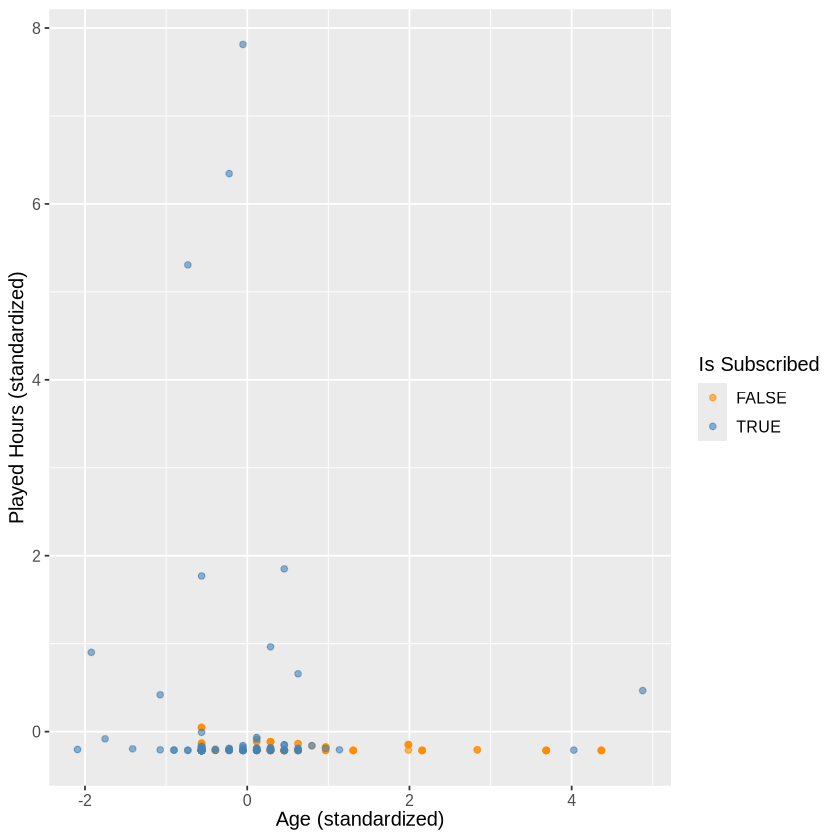

In [131]:
hours_age_plot <- ggplot(prep_data, aes(x = age, y = played_hours, color = is_subscribed)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (standardized)",
         y = "Played Hours (standardized)",
         color = "Is Subscribed") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 12))
hours_age_plot

At first sight, the visualization shows some outliers, especially in terms of played hours. It seems like most of the players who are subscribed have either a relatively long play time or low age.

## Model Training

### Preprocessing Recipe
The data preprocessing steps explained earlier are consolidated into a recipe that can be fed into the workflow along with the model specification.

In [150]:
players_recipe <- recipe(is_subscribed ~ ., data = players_train) |>
    step_normalize(all_predictors()) |>
    step_upsample(is_subscribed)

### Model Tuning

In [151]:
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular",
                                  neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [133]:
players_vfold <- vfold_cv(players_train, v = 10, strata = is_subscribed)

In [153]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

knn_tune_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_tune_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5318681,10,0.03595288,Preprocessor1_Model01
11,accuracy,binary,0.4694139,10,0.05132797,Preprocessor1_Model02
21,accuracy,binary,0.4821978,10,0.04200852,Preprocessor1_Model03
31,accuracy,binary,0.4274359,10,0.03316211,Preprocessor1_Model04
41,accuracy,binary,0.4775092,10,0.05545809,Preprocessor1_Model05
51,accuracy,binary,0.5158974,10,0.06695039,Preprocessor1_Model06
61,accuracy,binary,0.5973993,10,0.06253847,Preprocessor1_Model07
71,accuracy,binary,0.5786813,10,0.05314500,Preprocessor1_Model08
81,accuracy,binary,0.5677289,10,0.06045967,Preprocessor1_Model09


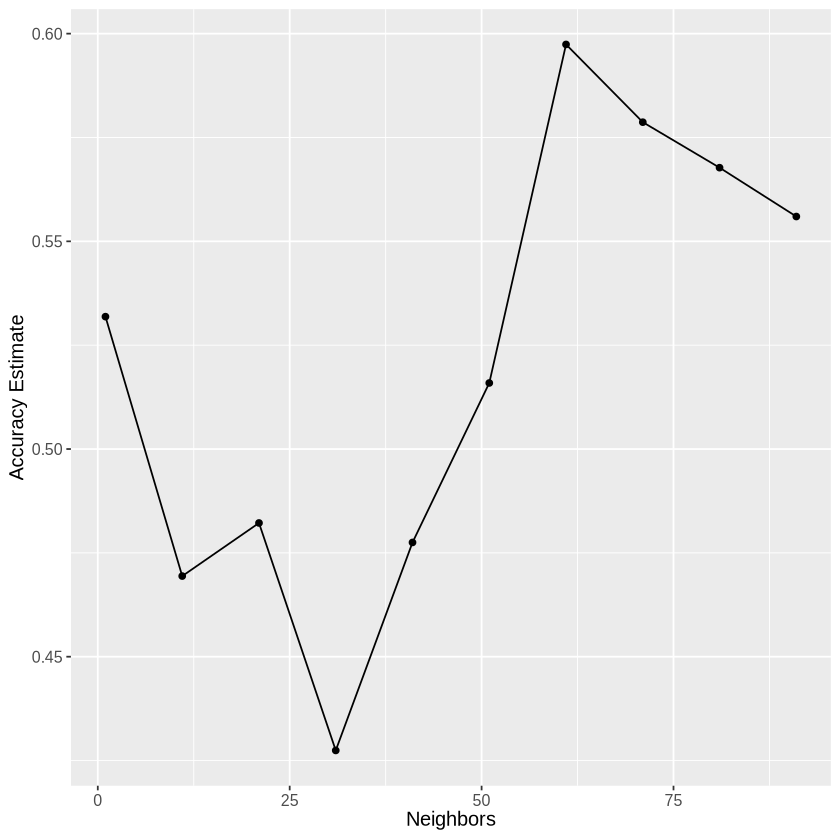

In [154]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

accuracy_vs_k

Both 61 and 91 neighbors exhibit a relatively high accuracy compared to other numbers of neighbors. Taking into account the computational cost, $K = 61$ is selected for the classifier.

### Model Fitting

In [156]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 61) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(61,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3632075
Best kernel: rectangular
Best k: 61

### Model Evaluation

In [157]:
players_test_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test)

players_test_predictions

.pred_class,is_subscribed,played_hours,age
<fct>,<fct>,<dbl>,<dbl>
FALSE,TRUE,3.8,17
TRUE,TRUE,0.0,17
FALSE,TRUE,48.4,17
FALSE,TRUE,0.5,17
TRUE,TRUE,0.7,21
FALSE,TRUE,0.6,28
TRUE,TRUE,0.0,17
TRUE,TRUE,0.1,21
TRUE,TRUE,0.0,17


In [158]:
players_test_predictions |>
    metrics(truth = is_subscribed, estimate = .pred_class) |>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5102041


In [159]:
players_test_predictions |> pull(is_subscribed) |> levels()

[1] "FALSE" "TRUE"

In [161]:
players_test_predictions |>
    precision(truth = is_subscribed, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7142857


In [162]:
players_test_predictions |>
    recall(truth = is_subscribed, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5555556


In [163]:
confusion <- players_test_predictions |>
    conf_mat(truth = is_subscribed, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     5   16
     TRUE      8   20